# load arome wind data and store

10 m/s = ?? Pa = BF = 5BF = 36 km/h = 19 knts

In [9]:
import os
from glob import glob
from tqdm import tqdm

%matplotlib inline
import matplotlib.pyplot as plt
import cmocean.cm as cm
import cartopy.crs as ccrs

import numpy as np
import pandas as pd
import xarray as xr

import pynsitu as pyn
crs = pyn.maps.crs

----

## load wind

In [5]:
data_dir = "/scale/project/oc-intranet/equinox/das/wemswot"
zarr = os.path.join(data_dir, "wind_arome.zarr")
ds = xr.open_zarr(zarr)
# adjust stress such that it's not a cummulled estimate
# see https://donneespubliques.meteofrance.fr/client/document/description_parametres_modeles-arpege-arome-v2_184.pdf
ds["ustress"] = ds["ustress"]/3600
ds["vstress"] = ds["vstress"]/3600
ds["speed10m"] = np.sqrt(ds.u10m**2+ds.v10m**2)
ds["dir10m"] = np.arctan2(ds.v10m, ds.u10m)*180/np.pi
ds["stress"] = np.sqrt(ds.ustress**2+ds.vstress**2)

# define points of interest
lonp = [5.904, 5.904]
latp = [43.045, 42.9]
labels = ["nearshore", "offshore"]


dsp = xr.Dataset(dict(lon=("point", lonp), lat=("point", latp)))
dsp = ds.interp(longitude=dsp.lon, latitude=dsp.lat).assign_coords(point=("point", labels))
dsp = dsp.compute()
#dsp["speed10m"] = np.sqrt(dsp.u10m**2+dsp.v10m**2)
#dsp["dir10m"] = np.arctan2(dsp.v10m, dsp.u10m)*180/np.pi
#dsp["stress"] = np.sqrt(dsp.ustress**2+dsp.vstress**2)

/home1/datawork/aponte/miniforge3/envs/emoi/lib/python3.10/site-packages/dask/config.py:787: FutureWarning: Dask configuration key 'distributed.scheduler.transition-log-length' has been deprecated; please use 'distributed.admin.low-level-log-length' instead
  warnings.warn(
/home1/datawork/aponte/miniforge3/envs/emoi/lib/python3.10/site-packages/dask/config.py:787: FutureWarning: Dask configuration key 'distributed.comm.recent-messages-log-length' has been deprecated; please use 'distributed.admin.low-level-log-length' instead
  warnings.warn(


In [17]:
lon = slice(5, 7)
lat = slice(42, 43.5)

In [2]:
#from dashydro import deployments_info, geo_domains, plot_map
#import dashydro.hydro as hy
#import pynsitu as pin

### map with point locations

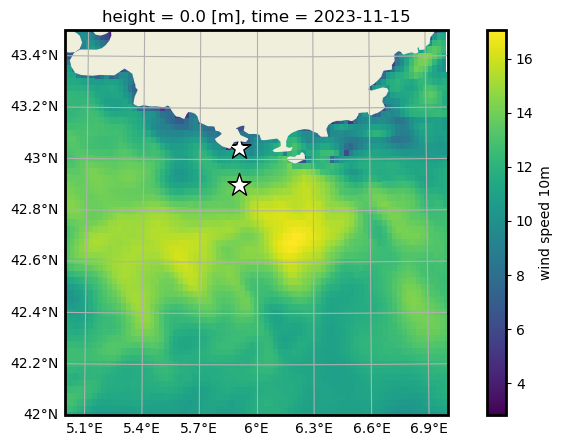

In [22]:
_ds = ds.sel(time="2023/11/15 00:00:00")

extent = [5,7,42,43.5]

#fig, ax, _ = plot_map(_ds.u10m)
fig, ax, _ = pyn.maps.plot_map(extent=extent, land="10m", coastline=False)

#ax.plot(_ds.longitude, _ds.latitude, _ds.u10m, transform=crs)
da = np.sqrt(_ds["u10m"]**2 + _ds["v10m"]**2).rename("wind speed 10m")
da.plot(x="longitude", y="latitude", transform=crs, zorder=0)

ax.scatter(x=dsp.longitude, y=dsp.latitude, 
           s=300,
           facecolor="w",
           edgecolor="k",
           marker="*",
           transform=ccrs.PlateCarree())

### time series

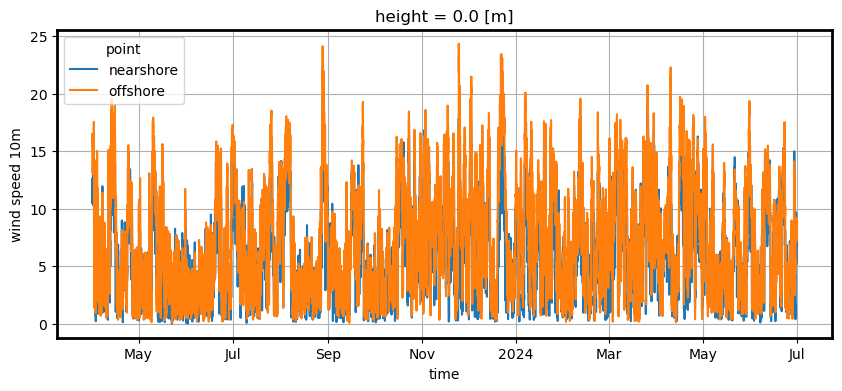

In [25]:
fig, ax = plt.subplots(1,1, figsize=(10,4))
da = np.sqrt(dsp["u10m"]**2 + dsp["v10m"]**2).rename("wind speed 10m")
da.plot.line(x="time")
ax.grid()

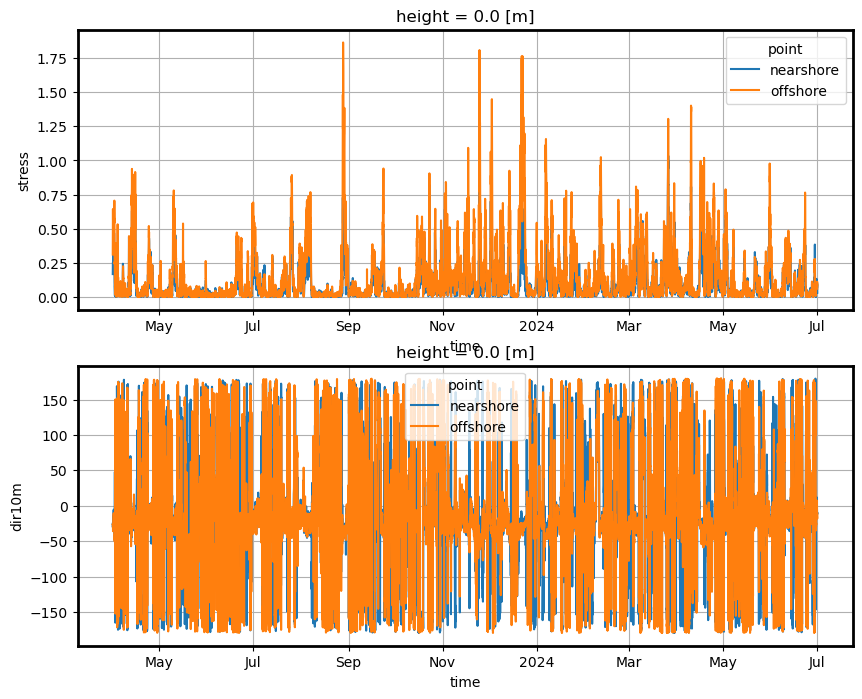

In [26]:
fig, axes = plt.subplots(2,1, figsize=(10,8))

ax = axes[0]
dsp.stress.plot.line(x="time", ax=ax)
ax.grid()

ax = axes[1]
dsp.dir10m.plot.line(x="time", ax=ax)
ax.grid()


Text(0.5, 1.0, 'wind stress')

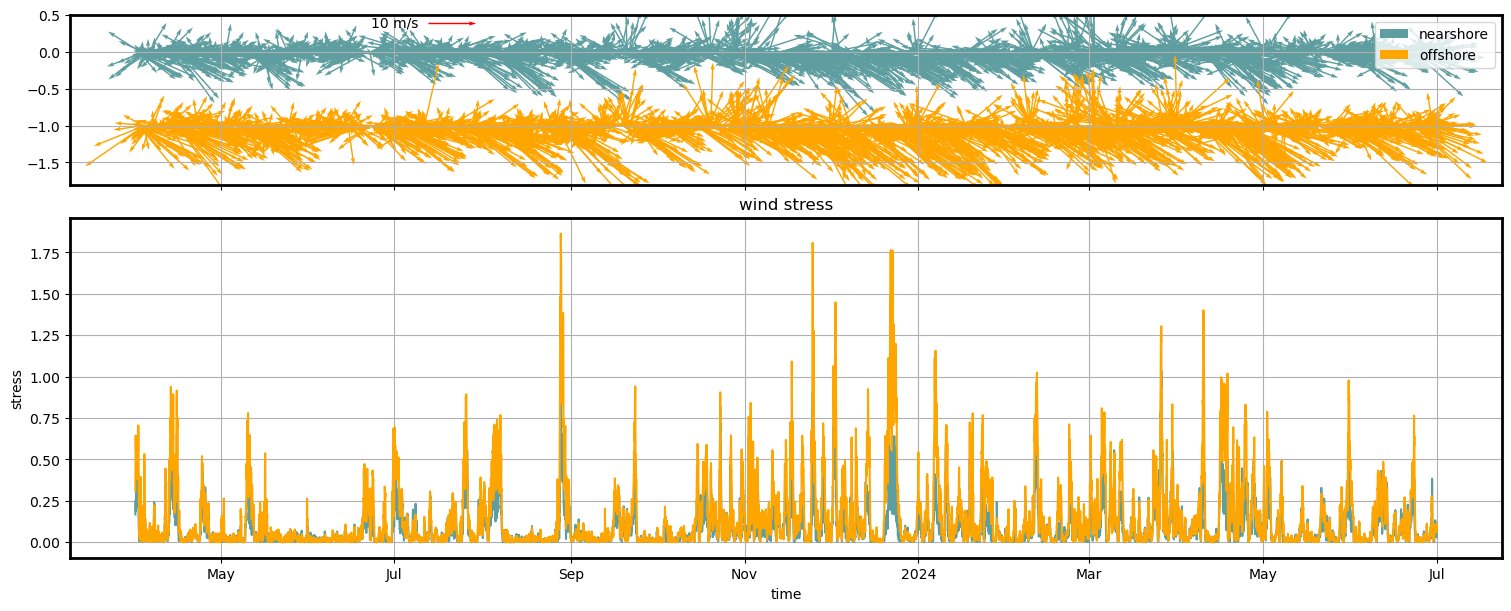

In [28]:
colors=["cadetblue", "orange"]

figsize=(15,6)

gs_kw = dict(height_ratios=[.5, 1])
fig, axd = plt.subplot_mosaic([['top'],['bottom']],
                              gridspec_kw=gs_kw, figsize=figsize,
                              constrained_layout=True, sharex=True)
# bathy
ax = axd["top"]
#ax.plot([dinfo["start"], dinfo["end"]], -.5*np.ones(2), lw=10, color=".5")

di = 3
akwargs = dict(scale=3e2, width=1e-3)

off=0
for pt, c in zip(dsp.point.values, colors):
    _ds = dsp.sel(point=pt).isel(time=slice(0,None,di))
    q = ax.quiver(_ds.time,np.zeros(_ds.time.size)+off, _ds.u10m,  _ds.v10m, color=c, label=pt, **akwargs)
    off+=-1
ax.set_ylim(-1.8, .5)
ax.legend()
qk = ax.quiverkey(q, 0.25, 0.95, 10, '10 m/s', transform=ccrs.PlateCarree(), color="r",
                  labelpos='W', coordinates='axes', zorder=10)
ax.grid()

#

ax = axd["bottom"]
#ax.plot([dinfo["start"], dinfo["end"]], [-.1, -.1], lw=10, color=".5")
for pt, c in zip(dsp.point.values, colors):
    dsp.sel(point=pt).stress.plot.line(x="time", ax=ax, color=c)
ax.grid()
ax.set_title("wind stress")


In [32]:
t = ds.time[0]

def map_wind(ds):


    #fig, ax, _ = plot_map(_ds.u10m)
    fig, ax, _ = pyn.maps.plot_map(extent=extent, land="10m", coastline=False)

    da = ds["stress"]
    da.plot(x="longitude", y="latitude", vmax=1, transform=crs, zorder=0)
    
    ax.scatter(x=dsp.longitude, y=dsp.latitude, 
               s=300,
               facecolor="w",
               edgecolor="k",
               marker="*",
               transform=ccrs.PlateCarree())

    dsq = ds.isel(longitude=slice(0,None,4), latitude=slice(0,None,4))
    q = dsq.plot.quiver(x="longitude", y="latitude", u="u10m", v="v10m", scale=1e2,
                        color="w",
                        transform=ccrs.PlateCarree(), zorder=2)
    qk = ax.quiverkey(q, 0.25, 0.95, 10, '10 m/s', transform=ccrs.PlateCarree(), color="r",
                      labelpos='W', coordinates='axes', zorder=10)
    
    return fig

In [33]:
_ds = ds.sel(time=slice("2023/11/01 00:00", "2023/11/10 00:00"))

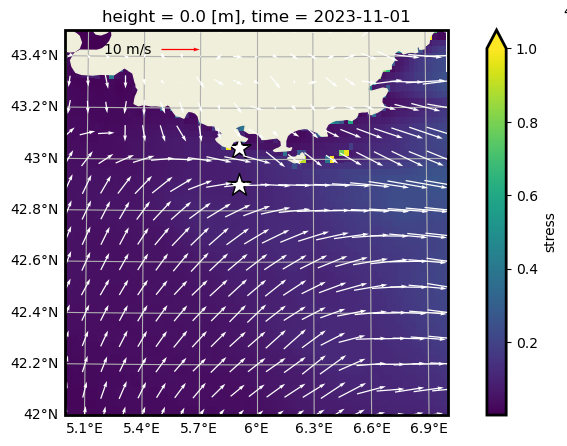

In [34]:
i = 0

t = _ds.time[i]
fig = map_wind(_ds.sel(time=t))

In [22]:
# store figures

i=0
for t in tqdm(_ds.time):
    fig = map_wind(_ds.sel(time=t))
    figfile = os.path.join(f"/Users/aponte/tmp/figs/{i:03d}.png")
    fig.savefig(figfile, dpi=150, bbox_inches = "tight", facecolor='white', transparent=False)
    plt.close(fig)
    i+=1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 481/481 [04:44<00:00,  1.69it/s]
